In [1]:
%pip install torch torchvision matplotlib

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of batches in training loader: {len(train_loader)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 66.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 17.0MB/s]

Number of training samples: 60000
Number of batches in training loader: 469


In [3]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape):
        super().__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, int(torch.prod(torch.tensor(img_shape)))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *self.img_shape)
        return img

# testing
latent_dim = 100
img_shape = (1, 28, 28)
generator = Generator(latent_dim, img_shape)
print(generator)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Tanh()
  )
)


In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_shape):
        super().__init__()
        self.img_shape = img_shape

        self.model = nn.Sequential(
            nn.Linear(int(torch.prod(torch.tensor(img_shape))), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() # using Sigmoid for binary classification output
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# testing
img_shape = (1, 28, 28)
discriminator = Discriminator(img_shape)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [5]:
import torch.optim as optim
import torch.nn as nn

adversarial_loss = nn.BCELoss()

learning_rate = 0.0002
beta1 = 0.5
beta2 = 0.999
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))

optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))


In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

generator.to(device)
discriminator.to(device)

num_epochs = 50

# training loop
print("Starting training loop...")
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):

        real_imgs = imgs.to(device)
        real_labels = torch.ones(imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(imgs.size(0), 1).to(device)

        optimizer_d.zero_grad()

        real_output = discriminator(real_imgs)
        d_loss_real = adversarial_loss(real_output, real_labels)

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z).detach()

        fake_output = discriminator(fake_imgs)
        d_loss_fake = adversarial_loss(fake_output, fake_labels)

        d_loss = (d_loss_real + d_loss_fake) / 2

        d_loss.backward()
        optimizer_d.step()

        optimizer_g.zero_grad()

        z = torch.randn(imgs.size(0), latent_dim).to(device)
        fake_imgs = generator(z)

        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)

        g_loss.backward()
        optimizer_g.step()

        if (i + 1) % 100 == 0:
            print(
                f"[Epoch {epoch}/{num_epochs}] [Batch {i+1}/{len(train_loader)}] "
                f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]"
            )

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            z = torch.randn(25, latent_dim).to(device)
            generated_images = generator(z).cpu()
            print(f"Epoch {epoch+1}: Generated sample images.")

print("Training finished.")

Using device: cuda
Starting training loop...
[Epoch 0/50] [Batch 100/469] [D loss: 0.4075] [G loss: 0.9775]
[Epoch 0/50] [Batch 200/469] [D loss: 0.4712] [G loss: 1.2256]
[Epoch 0/50] [Batch 300/469] [D loss: 0.4142] [G loss: 1.2345]
[Epoch 0/50] [Batch 400/469] [D loss: 0.5106] [G loss: 0.8233]
[Epoch 1/50] [Batch 100/469] [D loss: 0.1635] [G loss: 2.8951]
[Epoch 1/50] [Batch 200/469] [D loss: 0.3069] [G loss: 1.7990]
[Epoch 1/50] [Batch 300/469] [D loss: 0.6719] [G loss: 0.6273]
[Epoch 1/50] [Batch 400/469] [D loss: 0.4897] [G loss: 1.5900]
[Epoch 2/50] [Batch 100/469] [D loss: 0.1755] [G loss: 4.7635]
[Epoch 2/50] [Batch 200/469] [D loss: 0.2239] [G loss: 1.8605]
[Epoch 2/50] [Batch 300/469] [D loss: 0.7826] [G loss: 1.6319]
[Epoch 2/50] [Batch 400/469] [D loss: 0.4031] [G loss: 1.0155]
[Epoch 3/50] [Batch 100/469] [D loss: 0.3118] [G loss: 1.3652]
[Epoch 3/50] [Batch 200/469] [D loss: 0.2353] [G loss: 3.6058]
[Epoch 3/50] [Batch 300/469] [D loss: 0.1413] [G loss: 3.5943]
[Epoch 3/5

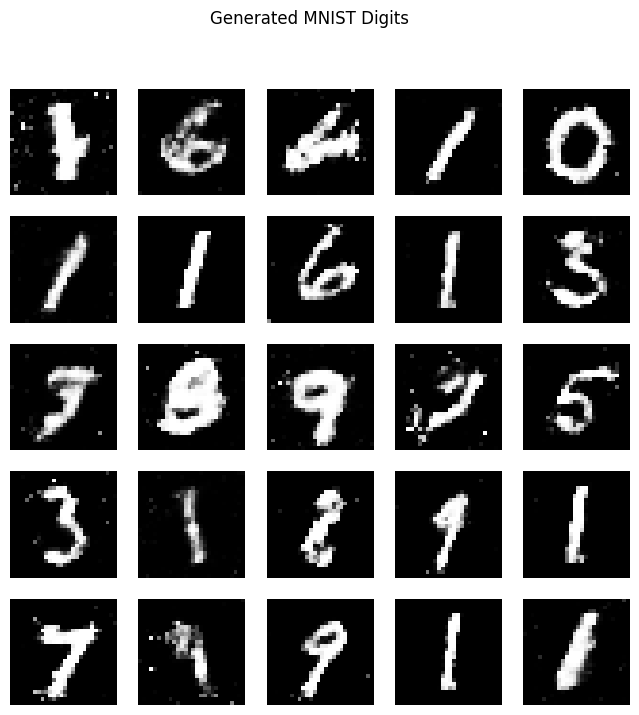

In [7]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    z = torch.randn(25, latent_dim).to(device)
    generated_images = generator(z).cpu()

fig, axes = plt.subplots(5, 5, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(generated_images[i].permute(1, 2, 0).numpy()), cmap='gray')
    ax.axis('off')
plt.suptitle("Generated MNIST Digits")
plt.show()